# Optimize Pizzeria Promotion Policy

Caution : This work is applied to a synthetic dataset. This is a theoretical exercice. If you want to apply this to your reel life data, please do further analysis and try modify the work to your assumptions and initial hypothesis 

<img src="/Users/lucasduthu-paloumet/Desktop/20220211142754-margherita-9920_0483214a-7057-4277-9a3b-f2ab17c01e13.jpg" width="600">

**Business use case : A pizza chain company ask us to optimize their promotion policy**

Context and initial assumptions: 
* The pizza company has placed randomly it's promotion in time and with a random intensity (10%, 20%, 50%...)
* In order to simplify this work, we'll approximate the profit of the firm as the revenue. This way, we'll only consider the selling price of the pizza, not it's cost of making. 
* We'll not include the effect of exeptionnal events such as sports events or christmas. 
* Also, we'll not include the effect of a promotion in geographically close restaurants. Which must have been interesting in a real world dataset. 

## Introduction

Variables description : 
- product_id : pannel 
- date : datetime
- sales : quantity sold (float because no units)
- promotion : promotion as a portion of the price (0.5 = 50% promotion)
- product_name : name of the product (same as product_id but with the name)
- initial_price : price before promotion
- sell_price : price after reduction 

### Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', UserWarning)

import time

from itertools import product

from tqdm.notebook import tqdm

from scipy.fft import fft
from scipy import stats

import statsmodels as ss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.seasonal import MSTL
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor


#import pmdarima as pm

np.random.seed(8)      
         
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.2

In [2]:
def fft_analysis(signal):
    
    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1)
    trend = np.arange(len(signal)) * slope + intercept 
    detrended = signal - trend 
    
    fft_values = fft(detrended)
    frequencies = np.fft.fftfreq(len(fft_values))

    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0]

    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)]
    print(f"Dominant Frequency: {dominant_frequency:.3f}")

    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")
    
    return dominant_period, positive_frequencies, magnitudes

In [3]:
def residuals_analysis(fitted_model, hist_bins=20, cor_lag=10, lj_lags=10) :
    residuals = fitted_model.resid

    _, ax = plt.subplots(2,2, figsize=(12, 7))
    plt.subplots_adjust(hspace=0.35)

    # Residuals
    ax[0,0].plot(residuals, alpha=0.6)
    ax[0,0].hlines(y=0, xmin=residuals.index[0], xmax=residuals.index[-1], linewidth=1)
    ax[0,0].set_title('Standardize Residuals for "S"')

    # QQ Plot
    qqplot(residuals, line='s', ax=ax[1,0], alpha= 0.5)
    ax[1,0].set_title('QQ-Plot of Residuals')

    # ACF Plot 
    plot_acf(residuals, lags=cor_lag, ax=ax[1,1])
    ax[1,1].set_title('Correlogram')

    # Hist plot
    ax[0,1].hist(residuals, bins=hist_bins, alpha=0.7, density=True)

    xmin, xmax = ax[0,1].set_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
    ax[0,1].plot(x, p, linewidth=2)
    title = "Fit Results: mu = %.2f,  std = %.2f" % (np.mean(residuals), np.std(residuals))
    ax[0,1].set_title(title)
    
    plt.show()

In [4]:
def decomp_plot() : 
    sub = mstl.seasonal.seasonal_365.iloc[:365*2] + mstl.seasonal.seasonal_30.iloc[:365*2] + mstl.seasonal.seasonal_7.iloc[:365*2] #+ res.trend.iloc[:365*1] 
    plt.figure(figsize=(10, 3))
    sub.plot(alpha=0.7)
    plt.title('Seasonality pattern')
    plt.show()

    _, ax = plt.subplots(1, 3, figsize=(15, 3))

    sub1 = mstl.seasonal.seasonal_7.iloc[:7*1] 
    sub2 = mstl.seasonal.seasonal_30.iloc[:30*1] 
    sub3 = mstl.seasonal.seasonal_365.iloc[:365*1] 
    ax[0].plot(sub1, alpha=0.7)
    ax[0].set_title('Weekly seasonality pattern')
    ax[1].plot(sub2, alpha=0.7)
    ax[1].set_title('Monthly seasonality pattern')
    ax[2].plot(sub3, alpha=0.7)
    ax[2].set_title('Yearly seasonality pattern')
    plt.show()


In [220]:
def f_plot(serie, data, product) : 
    sub = data[data['product_id'] == product].iloc[:365*2]

    plt.figure(figsize=(16,7))
    #plt.plot(sub['date'], sub[serie], label='Sales', alpha=0.7)
    plt.scatter(sub['date'], sub[serie], c=sub['promotion'], cmap='Reds', label='Promotion intensity', alpha=0.5)
    plt.title(f"Sales for {product} with promotion intensity")
    plt.colorbar(label="Promotion intensity")
    #plt.legend()
    plt.show()

### Feature engineering

In [6]:
df = pd.read_csv('/Users/lucasduthu-paloumet/Desktop/simulated_retail_data.csv') # Import data

# Duplicate indexes columns 
df['date'] = pd.to_datetime(df.date)
df['Date'] = df['date']
df['id'] = df['product_id']
df = df.set_index(['Date']) #id

df['sales'] = df['sales'].clip(lower=0) # Admit that all negative values for sales are 0

df['promo'] = (df['promotion'] != 0).astype(int) # Create a binary variable (promo) which is equal to 1 if promotion is different to 0 

df['sell_price'] = df['initial_price'] - (df['initial_price'] * df['promotion']) # Create sell_price as the price after promotion

# Create var for Y, M, D, and Dayofweek
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
df['dayofweek'] = df.date.dt.dayofweek

## Exploratory Data Analysis

In [7]:
df.isna().sum()

product_id       0
date             0
sales            0
promotion        0
product_name     0
initial_price    0
id               0
promo            0
sell_price       0
year             0
month            0
day              0
dayofweek        0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219000 entries, 1995-01-01 to 2024-12-23
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   product_id     219000 non-null  object        
 1   date           219000 non-null  datetime64[ns]
 2   sales          219000 non-null  float64       
 3   promotion      219000 non-null  float64       
 4   product_name   219000 non-null  object        
 5   initial_price  219000 non-null  float64       
 6   id             219000 non-null  object        
 7   promo          219000 non-null  int64         
 8   sell_price     219000 non-null  float64       
 9   year           219000 non-null  int32         
 10  month          219000 non-null  int32         
 11  day            219000 non-null  int32         
 12  dayofweek      219000 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(4), int64(1), object(3)
memory usage: 20.1+ MB


### Univariate

In [9]:
df.head()

,product_id,date,sales,promotion,product_name,initial_price,id,promo,sell_price,year,month,day,dayofweek
Date,,,,,,,,,,,,,
1995-01-01,Product_1,1995-01-01,90.494193,0.0,Margherita,8.5,Product_1,0,8.5,1995,1,1,6
1995-01-02,Product_1,1995-01-02,107.391727,0.0,Margherita,8.5,Product_1,0,8.5,1995,1,2,0
1995-01-03,Product_1,1995-01-03,108.317691,0.0,Margherita,8.5,Product_1,0,8.5,1995,1,3,1
1995-01-04,Product_1,1995-01-04,110.776536,0.0,Margherita,8.5,Product_1,0,8.5,1995,1,4,2
1995-01-05,Product_1,1995-01-05,107.522346,0.0,Margherita,8.5,Product_1,0,8.5,1995,1,5,3


In [10]:
df[['date', 'sales', 'promotion', 'initial_price', 'sell_price', 'promo']].describe()

,date,sales,promotion,initial_price,sell_price,promo
count,219000,219000.000000,219000.000000,219000.000000,219000.000000,219000.000000
mean,2009-12-27 12:00:00.000000256,136.363709,0.041176,11.150000,10.690876,0.149553
min,1995-01-01 00:00:00,0.000000,0.000000,8.500000,4.250474,0.000000
25%,2002-06-30 00:00:00,105.283027,0.000000,9.500000,9.500000,0.000000
50%,2009-12-27 12:00:00,134.842226,0.000000,11.000000,10.500000,0.000000
75%,2017-06-26 00:00:00,163.708049,0.000000,12.625000,12.500000,0.000000
max,2024-12-23 00:00:00,396.717500,0.499998,14.500000,14.500000,1.000000
std,NaN,44.715100,0.110360,1.803473,2.131385,0.356633


Text(0, 0.5, '')

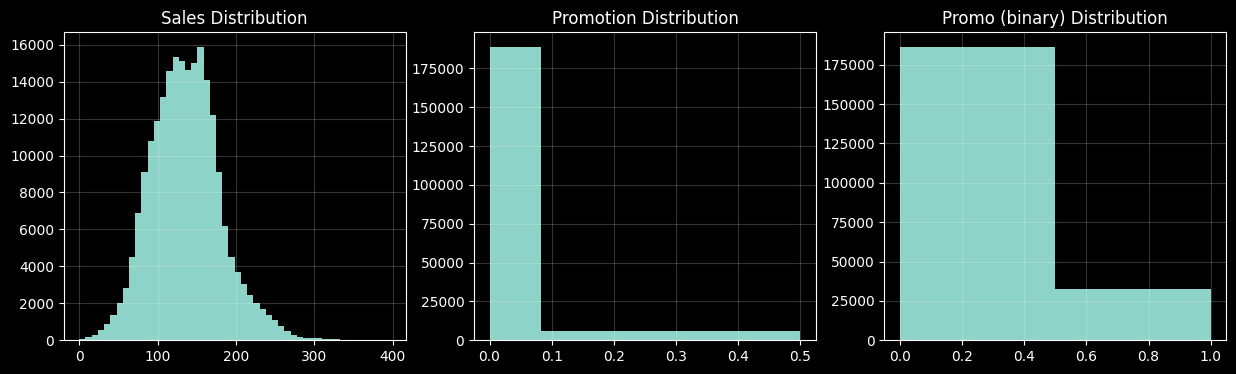

In [11]:
_, ax = plt.subplots(1, 3, figsize=(15, 4))
df.sales.plot(kind='hist', ax=ax[0], title='Sales Distribution', bins=50)
df.promotion.plot(kind='hist', ax=ax[1], title='Promotion Distribution', bins=6)
df.promo.plot(kind='hist', ax=ax[2], title='Promo (binary) Distribution', bins=2)
ax[0].set_ylabel(None)
ax[1].set_ylabel(None)
ax[2].set_ylabel(None)


### Bivariate

By looking at the distribution of sales for each product, we can easily see that every product has a different mean and std. But the shape of the distribution remain the same across products (two bumps aound the quartiles, squeezed on the middle) which means that all product sales responds to the same rules (globally). 

Additionnaly, we can see that each product distribution has a different upper spike of distribution. Some of them are very long, and some are smaller. We'll get more on this latter. 

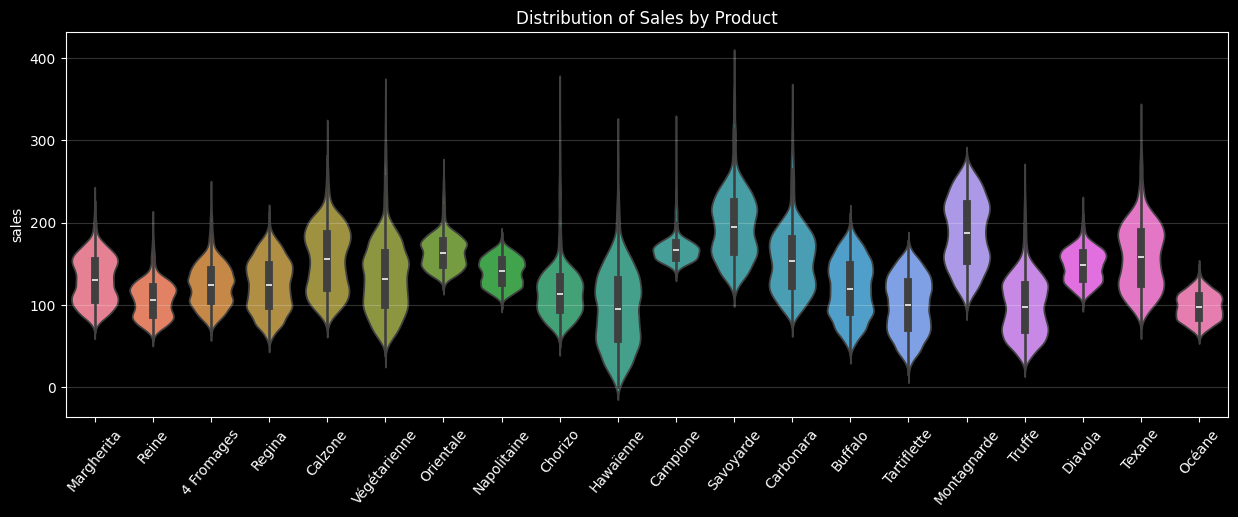

In [176]:
plt.figure(figsize=(15, 5))
sns.violinplot(data=df, 
               y='sales', 
               x='product_id', 
               width=0.8, 
               hue='product_id',
               #cmap='Blues'
               )
plt.xticks(range(20), df.product_name.unique(), rotation=50)
plt.title('Distribution of Sales by Product')
plt.xlabel(None)
plt.show()

### Time based

As we can see on the graphs below, 
- Graph 1 : their is a seasonality of the affluence in the pizzeria across the time. 
- Graph 2 : 
    - their is also particular seasonality for each product. 
    - And all the values that seems to quit the seasonality curve are most of the time affected by a high promotion intensivity. 

Text(0.5, 1.0, 'Sales (2018 - 2024)')

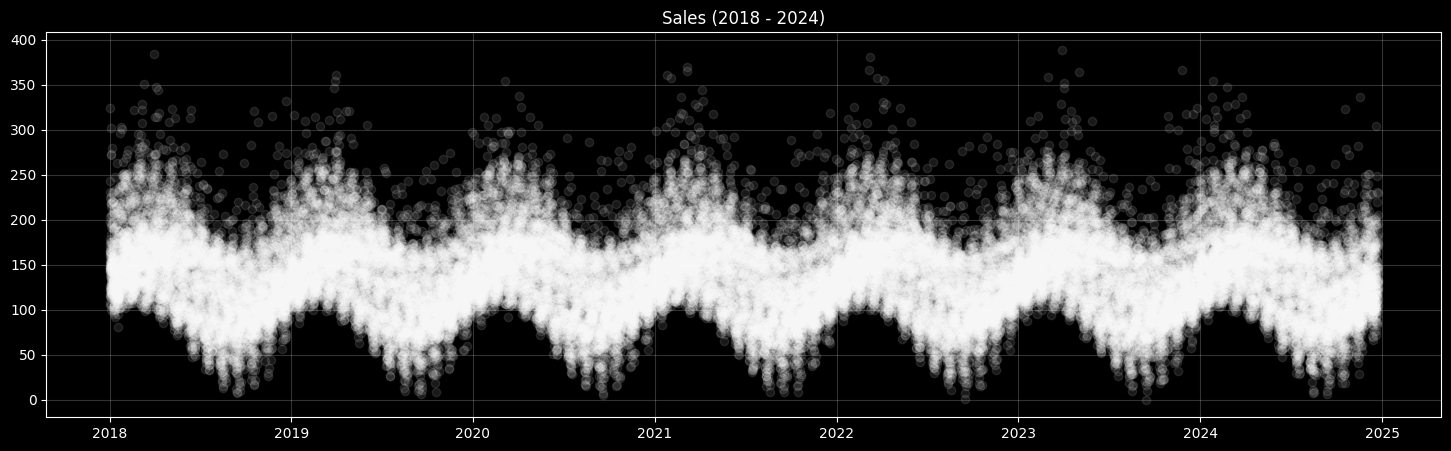

In [13]:
START_DATE = 2018
END_DATE = 2024


sub = df[(df.index.year >= START_DATE) & (df.index.year <= END_DATE)]

plt.figure(figsize=(18,5))
plt.scatter(x=sub.index, y=sub.sales, alpha=0.1, color='w')
plt.title(f'Sales ({START_DATE} - {END_DATE})')

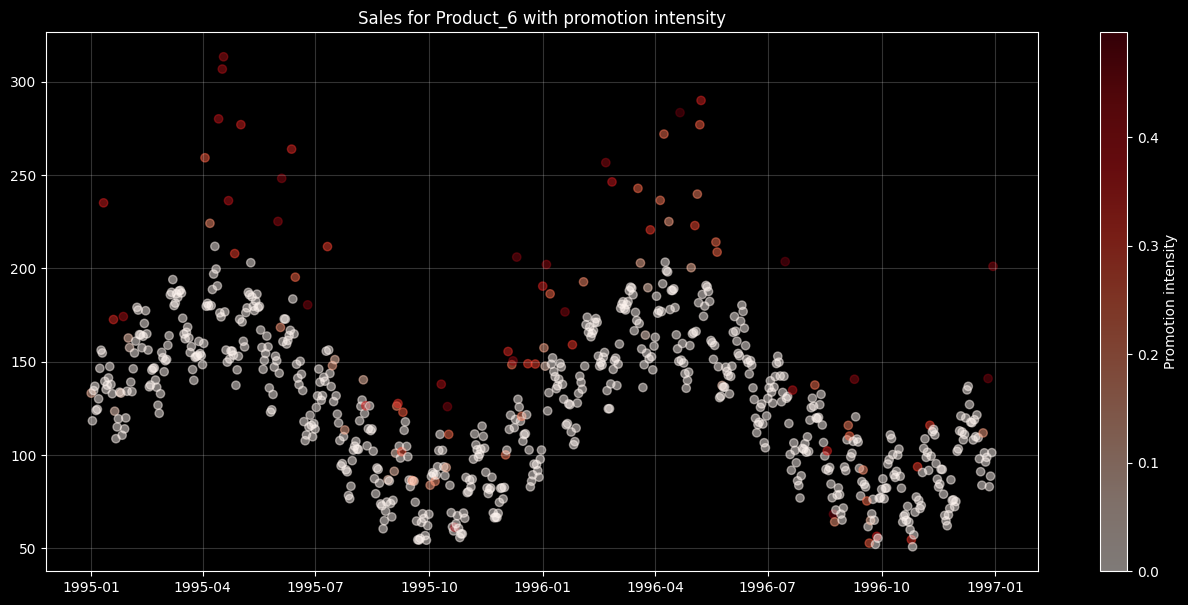

In [221]:
f_plot('sales', df, 'Product_6')

## Linear model devlopment 

The main purpose of building a linear model is to be able to explain the reel dynamics that explains what we try to predict. Most of the time, especially with time series, linear models are not the best type of models when it comes to predicting complex dataset. But it is important to do this analysis before going further in order to explore the schemas that matters throughout our dataset.

### Linear for one product

#### Explain the model

As my computer can't handle big models like SARIMAX(365), we'll only use decomposition model like MSTL. This way, we'll first try to approximate seasonality of the sales regarding different specs. And then try to modelise this throughout linear models. This way, the objective is to determine the effect of a promotion and it's intensity across different aspects. 

##### Feature engineering

As said earlier, promotions are randomly distributed across time and only represent a small portion of the dataset.
Assuming this, we can create a serie (no_promo) which is exactly sales column but with Nan when their is a promotion. 

As we'll perform MSTL, getting the mean of the values around a Nan seems a good idea. 
In fact : 
    as we assume that promotions are placed randomly
    and we assume that their is a seasonality (W, M, Y), we try to determine this seasonality.
And with this technique we'll reduice the loss of the distance with the seasonality extracted from other data-point.

In [247]:
df['no_promo'] = df['sales'].where(df['promotion'] == 0) # Create no_promo which is equal to sales when their is no promotion

df['no_promo'] = df['no_promo'].interpolate() # Interpolate, Nan as mean of the n-1 and n+1 values

##### Model mechanic

* Seasonality decomposition

As an exemple here, we run the model for product 1.

First, we decompose the weekly, monthly, yearly seasonality. We'll use the no_promo serie because we want to approximate the real seasonality without promotion. Also, if we were using the original sales serie, the promotion effect seasonality would be recorded in the decomposition. More on this later.

*Caution : As seen previously, the global seasonality and the seasonality of the product seems to echo with each other (as they are both sinusoïd-like curve). For the following exemple, we'll not try to separate thoses two effect.*

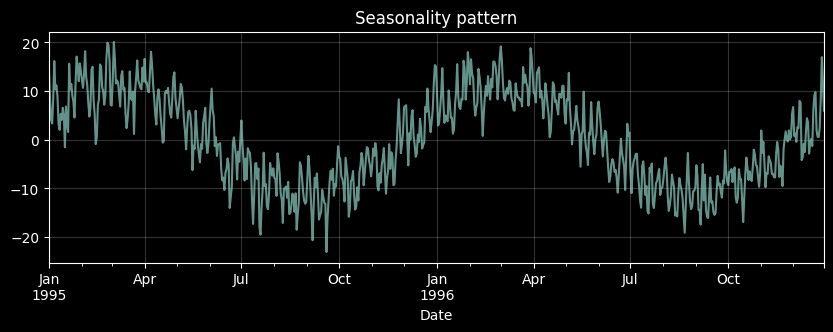

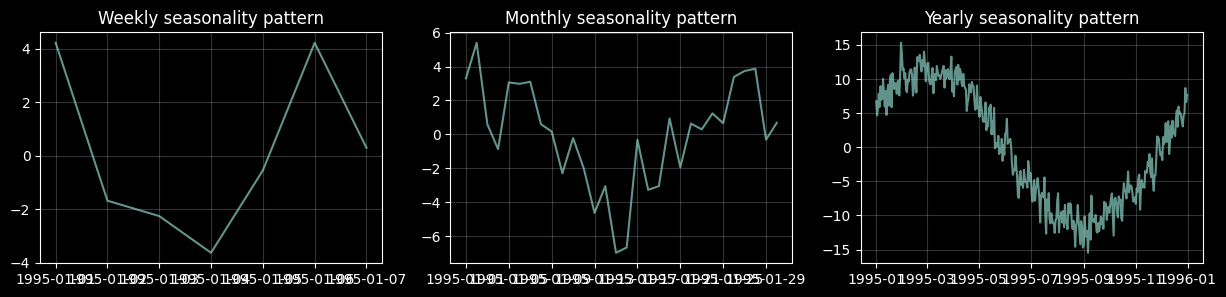

In [248]:
prod = 'Product_11' # Choose your product
sub = df[df.product_id == prod]

mstl = MSTL(sub["no_promo"], periods=(7, 30, 365)).fit()
decomp_plot()

- Fitting the model

Next step is to fit the model with the seasonal part and the promotion. 

As we can see on the result table below, we achived a very high $R^2$. Which means that a lot of the variance of the sales series is explain by our simple model. 

But this isn't sufficient. We have to analyse the residuals of the model to see if their is still something important that we haven't recorded with our model. 

In [249]:
sub['decomposition1'] = (
    mstl.seasonal.seasonal_7 + 
    mstl.seasonal.seasonal_30 + 
    mstl.seasonal.seasonal_365 # + mstl.trend
    )

formula = "sales ~ decomposition1 + promotion"

model = smf.ols(formula, data=sub).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                 1.262e+04
Date:                Tue, 18 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:35:06   Log-Likelihood:                -42048.
No. Observations:               10950   AIC:                         8.410e+04
Df Residuals:                   10947   BIC:                         8.412e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        163.8048      0.115   1425.

* Residuals analysis

The residuals has to be : 
- Homoscedastic
- Normally distributed
- No autocarrelated
- Not seasonal

As we can see below, in this case, the residuals are :
- Visually normally distributed
But : 
- Has a strong seasonality as we can see on graph 4. 
- And still autocorrelated

Which means that their is still something that our model is enable to capture. 

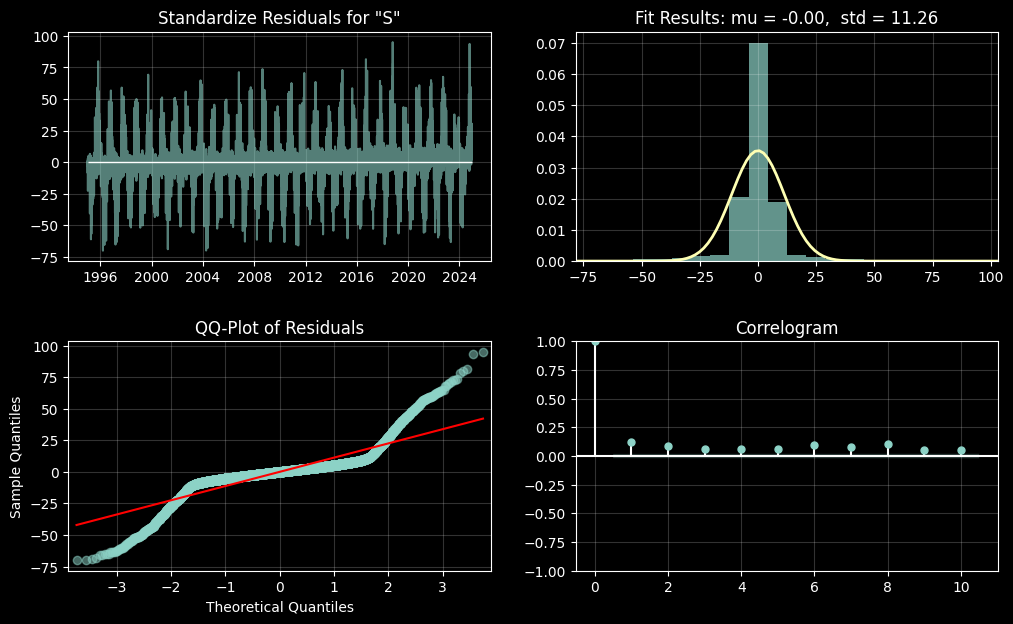

In [250]:
residuals_analysis(model)

As we can see on the graph below, the model did a good job predicting the data-point with no promotion. 

But we can also see that as the promotion increase, the sales predicted values increase linearly. But this is not the case in the actual data. In fact, we can see that throughout the year, the effect of a promotion on the sales fluctuate. 

This is what our model do not catch. 

In [251]:
sub['y_hat'] = model.predict(sub)

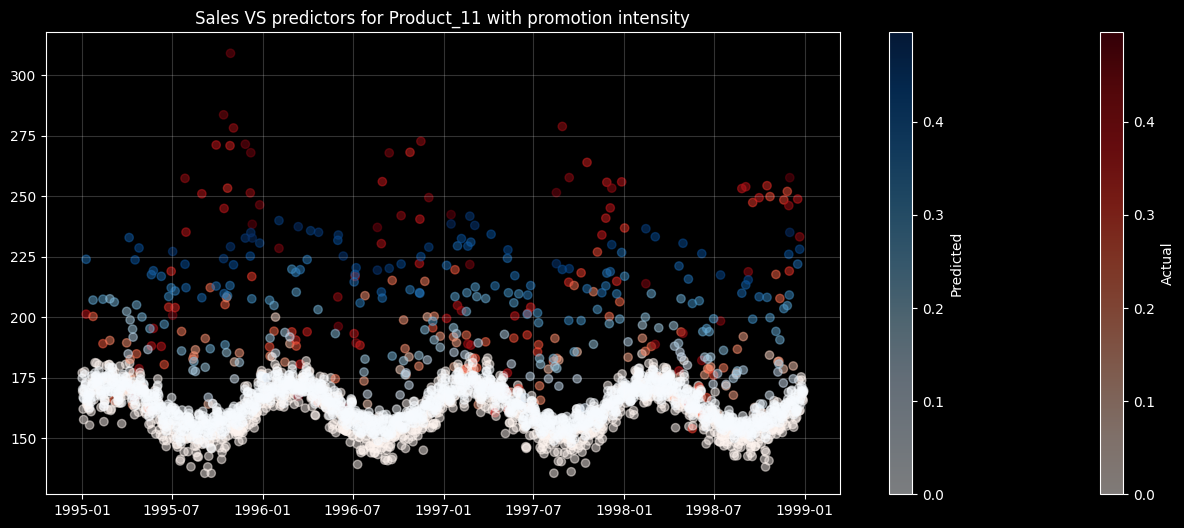

In [252]:
serie = 'sales'
data = sub
product = 'Product_11'

sub = data[data['product_id'] == product].iloc[:365*4]

plt.figure(figsize=(16,6))
#plt.plot(sub['date'], sub[serie], label='Sales', alpha=0.7)
plt.scatter(sub['date'], sub[serie], c=sub['promotion'], cmap='Reds', label='Promotion intensity', alpha=0.5)
plt.colorbar(label="Actual")
plt.scatter(sub['date'], sub['y_hat'], c=sub['promotion'], cmap='Blues', label='Promotion intensity', alpha=0.5)
plt.colorbar(label="Predicted")
plt.title(f"Sales VS predictors for {product} with promotion intensity")
#plt.legend()
plt.show()

To toy-test it, we can try to do an interaction with each month as below.

In [253]:
formula = "sales ~ decomposition1 + promotion:C(month)"

model = smf.ols(formula, data=sub).fit()
print(model.summary())
sub['y_hat'] = model.predict(sub)

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1604.
Date:                Tue, 18 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:35:15   Log-Likelihood:                -4532.3
No. Observations:                1460   AIC:                             9093.
Df Residuals:                    1446   BIC:                             9167.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                160

We can see on the tab above that our $R^2$ increased significally. Which means that this new model explains a bigger part of the variance.

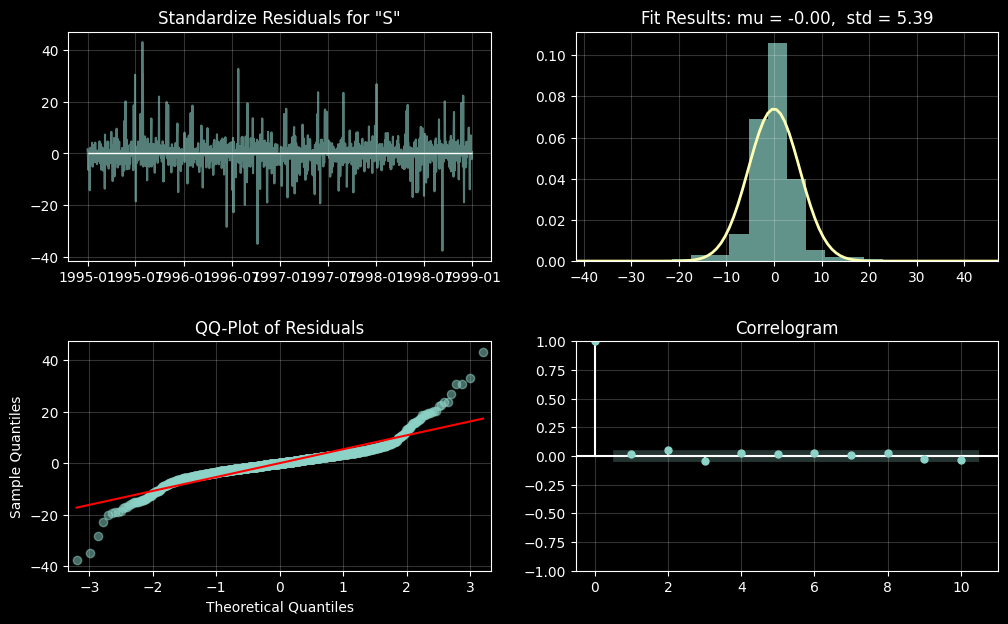

In [254]:
residuals_analysis(model)

The residuals have a better shape, they are not very well normally distributed but at least they are non autocorrelated.

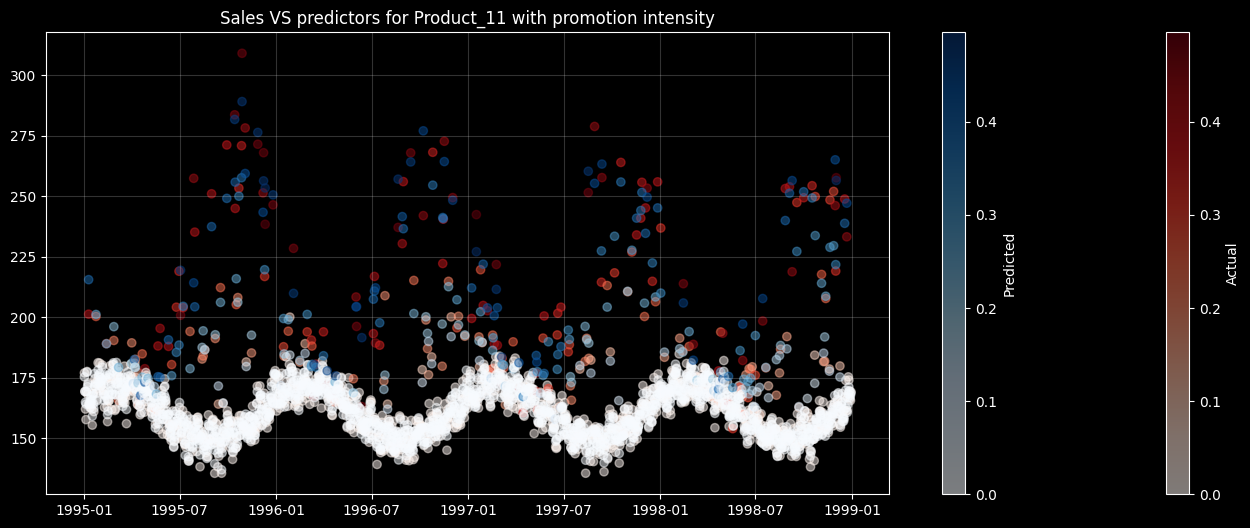

In [255]:
serie = 'sales'
data = sub
product = 'Product_11'

sub = data[data['product_id'] == product].iloc[:365*4]

plt.figure(figsize=(17,6))
#plt.plot(sub['date'], sub[serie], label='Sales', alpha=0.7)
plt.scatter(sub['date'], sub[serie], c=sub['promotion'], cmap='Reds', label='Promotion intensity', alpha=0.5)
plt.colorbar(label="Actual")
plt.scatter(sub['date'], sub['y_hat'], c=sub['promotion'], cmap='Blues', label='Promotion intensity', alpha=0.5)
plt.colorbar(label="Predicted")
plt.title(f"Sales VS predictors for {product} with promotion intensity")
#plt.legend()
plt.show()

Finally, on this last graph, we can see that our predictors are way better than with the last model.

#### Linear model generalized for all products

##### Global decomposition

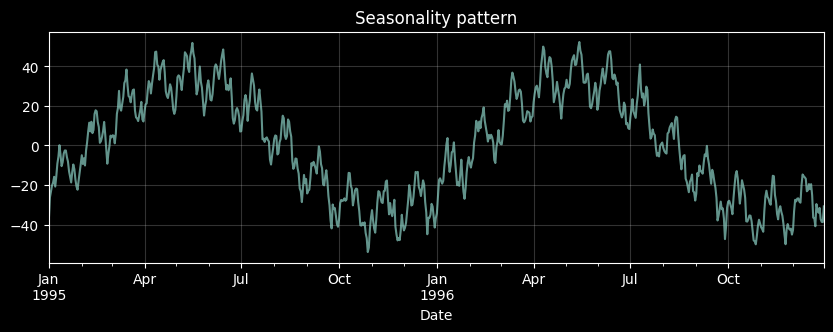

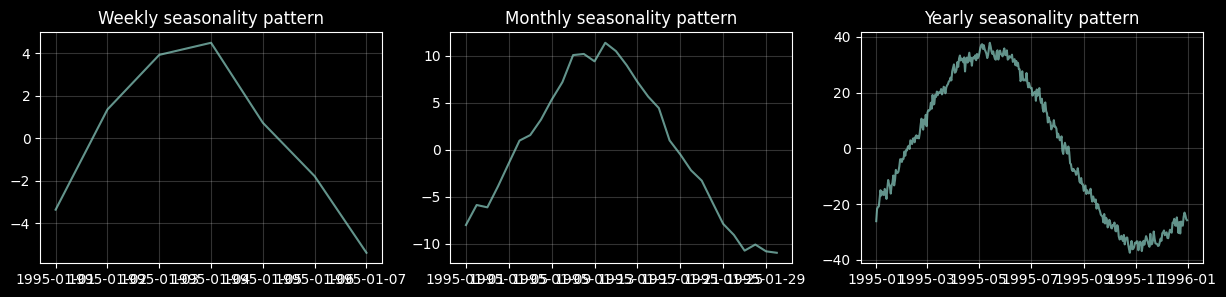

In [239]:
sub = df

mstl = MSTL(sub["no_promo"], periods=(7, 30, 365)).fit()
decomp_plot()

sub['decomposition1'] = (
    mstl.seasonal.seasonal_7 + 
    mstl.seasonal.seasonal_30 + 
    mstl.seasonal.seasonal_365 #+ mstl.trend
    )

##### Particular decomposition

In [240]:
sub3 = pd.DataFrame()
for each in sub.product_id.unique() : 
    sub2 = df[sub.product_id == each]
    sub2['no_promo_diff1'] = sub2['no_promo'] - sub2['decomposition1']
    
    mstl = MSTL(sub2["no_promo_diff1"], periods=(7, 30, 365)).fit()

    sub2['decomposition2'] = (
        mstl.seasonal.seasonal_7 + 
        mstl.seasonal.seasonal_30 + 
        mstl.seasonal.seasonal_365 
        #+ mstl.trend
        )
    
    sub3 = pd.concat([sub3, sub2], ignore_index=True)

##### Generalised model

In [241]:
formula = "sales ~ decomposition1 + decomposition2:C(product_id) + promotion:C(product_id):C(month) + C(product_id)" #dayofweek

model = smf.ols(formula, data=sub3).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 5.302e+04
Date:                Tue, 18 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:34:32   Log-Likelihood:            -6.7958e+05
No. Observations:              219000   AIC:                         1.360e+06
Df Residuals:                  218719   BIC:                         1.363e+06
Df Model:                         280                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [242]:
sub3['y_hat'] = model.predict(sub3)

r2 = r2_score(sub3.sales, sub3.y_hat)
mse = mean_squared_error(sub3.sales, sub3.y_hat)
print(f'MSE: {mse}')
print(f'R2: {r2}')

MSE: 29.030946462649332
R2: 0.9854803964251435


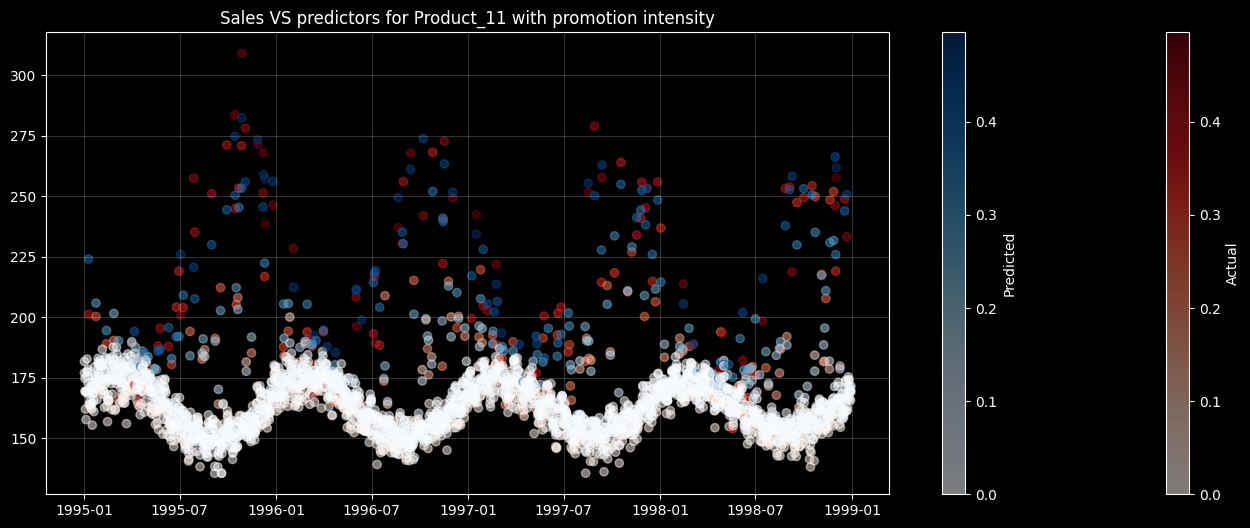

In [243]:
serie = 'sales'
data = sub3
product = 'Product_11'

sub = data[data['product_id'] == product].iloc[:365*4]

plt.figure(figsize=(17,6))

plt.scatter(sub['date'], sub[serie], c=sub['promotion'], cmap='Reds', label='Promotion intensity', alpha=0.5)
plt.colorbar(label="Actual")
plt.scatter(sub['date'], sub['y_hat'], c=sub['promotion'], cmap='Blues', label='Promotion intensity', alpha=0.5)
plt.colorbar(label="Predicted")
plt.title(f"Sales VS predictors for {product} with promotion intensity")
#plt.legend()
plt.show()

## Model Comparison

### Initialization

In [46]:
cpdf = df.reset_index()
cpdf.reset_index()
cpdf['year'] = cpdf.date.dt.year
cpdf = cpdf.sort_values(['id', 'year'])

# --- Paramètres ---
train_window = 16
test_window = 5

# Stockage des splits
splits = []

# Boucle sur les années possibles
min_year = cpdf['year'].min()
max_year = cpdf['year'].max()

for start_year in range(min_year, max_year - train_window - test_window + 2):
    train_start = start_year
    train_end   = start_year + train_window - 1
    test_end    = train_end + test_window

    # Séparation train/test pour chaque fenêtre
    train_mask = cpdf['year'].between(train_start, train_end)
    test_mask  = cpdf['year'].between(train_end + 1, test_end)

    train_set = cpdf.loc[train_mask].copy()
    test_set  = cpdf.loc[test_mask].copy()

    splits.append({
        "train_years": (train_start, train_end),
        "test_years": (train_end + 1, test_end),
        "train": train_set,
        "test": test_set
    })

# Exemple d'affichage
for i, s in enumerate(splits[:18], 1):
    print(f"Fold {i}: train {s['train_years']} → test {s['test_years']}")
    print(f"Train size = {s['train'].shape[0]}, Test size = {s['test'].shape[0]}")

Fold 1: train (1995, 2010) → test (2011, 2015)
Train size = 116880, Test size = 36520
Fold 2: train (1996, 2011) → test (2012, 2016)
Train size = 116880, Test size = 36540
Fold 3: train (1997, 2012) → test (2013, 2017)
Train size = 116880, Test size = 36520
Fold 4: train (1998, 2013) → test (2014, 2018)
Train size = 116880, Test size = 36520
Fold 5: train (1999, 2014) → test (2015, 2019)
Train size = 116880, Test size = 36520
Fold 6: train (2000, 2015) → test (2016, 2020)
Train size = 116880, Test size = 36540
Fold 7: train (2001, 2016) → test (2017, 2021)
Train size = 116880, Test size = 36520
Fold 8: train (2002, 2017) → test (2018, 2022)
Train size = 116880, Test size = 36520
Fold 9: train (2003, 2018) → test (2019, 2023)
Train size = 116880, Test size = 36520
Fold 10: train (2004, 2019) → test (2020, 2024)
Train size = 116880, Test size = 36380


### Linear regression

In [47]:
train_r2 = []
train_mse = []
cv_results_r2 = []
cv_results_mse = []

for fold, s in enumerate(splits, 1):
    train_set = pd.DataFrame(s['train'])
    test_set = pd.DataFrame(s['test'])

    sub3 = pd.DataFrame()
    test_set['decomposition2'] = np.nan 

    for each in train_set.product_id.unique():
        sub2 = train_set[train_set.product_id == each].copy()
        sub2['no_promo_diff1'] = sub2['no_promo']

        mstl_id = MSTL(sub2["no_promo_diff1"], periods=(7, 30, 365)).fit()
        sub2['decomposition2'] = (
            mstl_id.seasonal.seasonal_7 +
            mstl_id.seasonal.seasonal_30 +
            mstl_id.seasonal.seasonal_365
        )

        first_year_decomp2 = sub2['decomposition2'].iloc[:365].values
        test_sub = test_set[test_set.product_id == each]
        if not test_sub.empty:
            n_test_sub = len(test_sub)
            repeated_decomp2 = np.tile(first_year_decomp2, (n_test_sub // 365) + 1)[:n_test_sub]
            test_set.loc[test_sub.index, 'decomposition2'] = repeated_decomp2

        sub3 = pd.concat([sub3, sub2], ignore_index=True)

    formula = "sales ~ decomposition2:C(product_id) + promotion:C(product_id):C(month) + C(product_id)" 
    model = smf.ols(formula, data=sub3).fit()

    sub3['y_hat'] = model.predict(sub3)
    test_set['y_hat'] = model.predict(test_set)

    r2_train = r2_score(sub3["sales"], sub3["y_hat"])
    mse_train = mean_squared_error(sub3["sales"], sub3["y_hat"])

    r2_test = r2_score(test_set["sales"], test_set["y_hat"])
    mse_test = mean_squared_error(test_set["sales"], test_set["y_hat"])

    train_r2.append(r2_train)
    train_mse.append(mse_train)
    cv_results_r2.append(r2_test)
    cv_results_mse.append(mse_test)

    print(f"Fold {fold} TRAIN - R2 : {r2_train:.4f} | MSE : {mse_train:.4f}")
    print(f"Fold {fold} TEST  - R2 : {r2_test:.4f} | MSE : {mse_test:.4f}\n")


print("\n===== CV Results =====")
print(f"Moyenne R2 test : {np.mean(cv_results_r2):.4f}   (std = {np.std(cv_results_r2):.4f})")
print(f"Moyenne MSE test : {np.mean(cv_results_mse):.4f} (std = {np.std(cv_results_mse):.4f})")

Fold 1 TRAIN - R2 : 0.9876 | MSE : 24.7058
Fold 1 TEST  - R2 : 0.9171 | MSE : 166.0350

Fold 2 TRAIN - R2 : 0.9875 | MSE : 24.8064
Fold 2 TEST  - R2 : 0.9165 | MSE : 167.2160

Fold 3 TRAIN - R2 : 0.9875 | MSE : 24.7770
Fold 3 TEST  - R2 : 0.9164 | MSE : 167.9938

Fold 4 TRAIN - R2 : 0.9875 | MSE : 24.8579
Fold 4 TEST  - R2 : 0.9176 | MSE : 166.7464

Fold 5 TRAIN - R2 : 0.9876 | MSE : 24.6824
Fold 5 TEST  - R2 : 0.9165 | MSE : 169.2207

Fold 6 TRAIN - R2 : 0.9875 | MSE : 24.7943
Fold 6 TEST  - R2 : 0.9160 | MSE : 169.1120

Fold 7 TRAIN - R2 : 0.9876 | MSE : 24.7139
Fold 7 TEST  - R2 : 0.9172 | MSE : 167.3049

Fold 8 TRAIN - R2 : 0.9875 | MSE : 24.9451
Fold 8 TEST  - R2 : 0.9170 | MSE : 167.9081

Fold 9 TRAIN - R2 : 0.9875 | MSE : 24.9329
Fold 9 TEST  - R2 : 0.9165 | MSE : 168.3659

Fold 10 TRAIN - R2 : 0.9875 | MSE : 25.0104
Fold 10 TEST  - R2 : 0.9169 | MSE : 168.0537


===== CV Results =====
Moyenne R2 test : 0.9168   (std = 0.0004)
Moyenne MSE test : 167.7957 (std = 0.9479)


In [216]:
def model_analysis(mse, r2, train, test, color='w') :

    # Distribution MSE & R2
    _, ax = plt.subplots(1, 2, figsize=(10, 4))
    #ax[0].boxplot(mse)
    sns.stripplot(mse, ax=ax[0], color = color, size=6, alpha = 0.8)
    sns.violinplot(mse, ax=ax[0], width=0.2, color= color, alpha=0.5)
    ax[0].set_title("MSE Test Set")

    sns.stripplot(r2, ax=ax[1], color = color, size=6, alpha = 0.8)
    sns.violinplot(r2, ax=ax[1], width=0.2, alpha=0.5, color= color)
    ax[1].set_title("R2 Test Set")
    plt.show()

    # Results CV
    print("\n===== CV Results =====")
    print(f"Moyenne R2 test : {np.mean(cv_results_r2):.4f}   (std = {np.std(cv_results_r2):.4f})")
    print(f"Moyenne MSE test : {np.mean(cv_results_mse):.4f} (std = {np.std(cv_results_mse):.4f})")

    # Predicted VS Actual
    _, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].scatter(x=train.sales, y=train.y_hat, color= color, alpha=0.5)
    ax[0].set_title("Train - Predicted VS Actual")
    min_s, max_s = train.sales.min(), train.sales.max()
    ax[0].plot([min_s, max_s], [min_s, max_s], 'r--')

    ax[1].scatter(x=test.sales, y=test.y_hat, color = color, alpha=0.5)
    ax[1].set_title("Test - Predicted VS Actual")
    min_s, max_s = test.sales.min(), test.sales.max()
    ax[1].plot([min_s, max_s], [min_s, max_s], 'r--')
    plt.show()

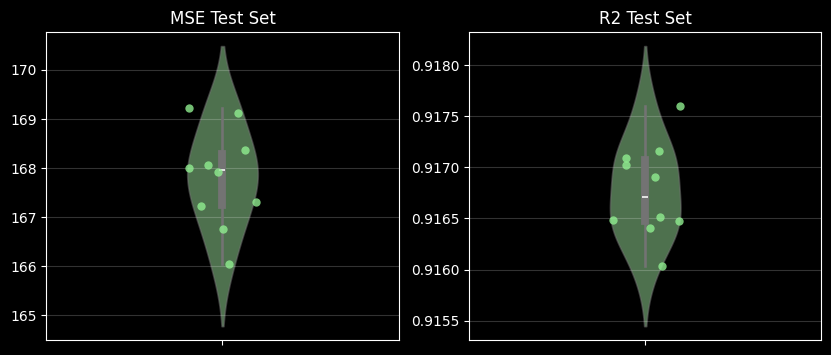


===== CV Results =====
Moyenne R2 test : 0.9168   (std = 0.0004)
Moyenne MSE test : 167.7957 (std = 0.9479)


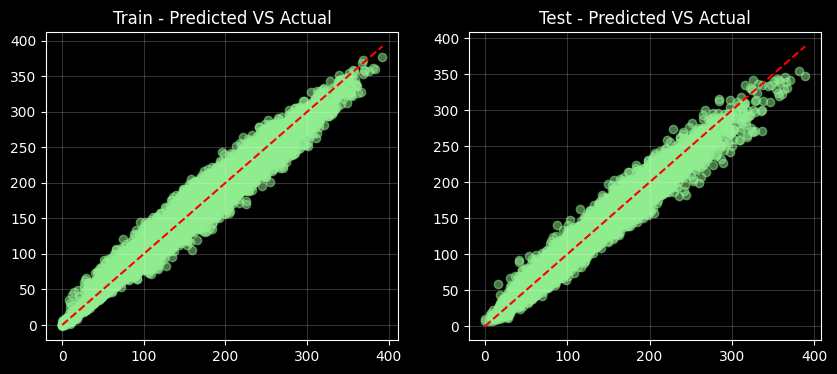

In [217]:
model_analysis(cv_results_mse, cv_results_r2, sub3, test_set, color='lightgreen')

### Decision tree

#### Standard model

In [50]:
tree = DecisionTreeRegressor(max_depth=20, random_state=42)

tree_train_r2 = []
tree_train_mse = []
tree_cv_results_r2 = []
tree_cv_results_mse = []

for fold, s in enumerate(splits, 1):

    # Convert to DataFrame
    train_set = pd.DataFrame(s["train"]).copy()
    test_set = pd.DataFrame(s["test"]).copy()

    # Encode product_id
    train_set["product_id_int"] = train_set["product_id"].astype("category").cat.codes
    test_set["product_id_int"] = test_set["product_id"].astype("category").cat.codes

    # Define features / target
    X_train = train_set.drop(columns=[
        'product_name', 'initial_price', 'id', 'promo', 'sell_price',
        'date', 'Date', 'no_promo', 'decomposition1', 'sales', 'product_id'
    ])
    X_test = test_set.drop(columns=[
        'product_name', 'initial_price', 'id', 'promo', 'sell_price',
        'date', 'Date', 'no_promo', 'decomposition1', 'sales', 'product_id'
    ])

    y_train = train_set['sales']
    y_test = test_set['sales']

    # Fit model
    tree.fit(X_train, y_train)

    # Predictions
    train_set['y_hat'] = tree.predict(X_train)
    test_set['y_hat'] = tree.predict(X_test)

    # === EVALUATION ===
    r2_train = r2_score(y_train, train_set['y_hat'])
    mse_train = mean_squared_error(y_train, train_set['y_hat'])

    r2_test = r2_score(y_test, test_set['y_hat'])
    mse_test = mean_squared_error(y_test, test_set['y_hat'])

    # Store results
    tree_train_r2.append(r2_train)
    tree_train_mse.append(mse_train)
    tree_cv_results_r2.append(r2_test)
    tree_cv_results_mse.append(mse_test)

    print(f"Fold {fold} TRAIN - R2 : {r2_train:.4f} | MSE : {mse_train:.4f}")
    print(f"Fold {fold} TEST  - R2 : {r2_test:.4f} | MSE : {mse_test:.4f}\n")

print("\n===== CV Results =====")
print(f"Moyenne R2 test : {np.mean(tree_cv_results_r2):.4f}   (std = {np.std(tree_cv_results_r2):.4f})")
print(f"Moyenne MSE test : {np.mean(tree_cv_results_mse):.4f} (std = {np.std(tree_cv_results_mse):.4f})")

Fold 1 TRAIN - R2 : 0.9963 | MSE : 7.4376
Fold 1 TEST  - R2 : 0.9606 | MSE : 78.8209

Fold 2 TRAIN - R2 : 0.9963 | MSE : 7.3070
Fold 2 TEST  - R2 : 0.9592 | MSE : 81.6250

Fold 3 TRAIN - R2 : 0.9961 | MSE : 7.7080
Fold 3 TEST  - R2 : 0.9596 | MSE : 81.1680

Fold 4 TRAIN - R2 : 0.9961 | MSE : 7.8354
Fold 4 TEST  - R2 : 0.9610 | MSE : 78.9633

Fold 5 TRAIN - R2 : 0.9962 | MSE : 7.4791
Fold 5 TEST  - R2 : 0.9615 | MSE : 78.0196

Fold 6 TRAIN - R2 : 0.9962 | MSE : 7.5204
Fold 6 TEST  - R2 : 0.9579 | MSE : 84.6960

Fold 7 TRAIN - R2 : 0.9962 | MSE : 7.5672
Fold 7 TEST  - R2 : 0.9590 | MSE : 82.9054

Fold 8 TRAIN - R2 : 0.9951 | MSE : 9.7159
Fold 8 TEST  - R2 : 0.9586 | MSE : 83.7950

Fold 9 TRAIN - R2 : 0.9952 | MSE : 9.5004
Fold 9 TEST  - R2 : 0.9564 | MSE : 87.8751

Fold 10 TRAIN - R2 : 0.9955 | MSE : 8.9448
Fold 10 TEST  - R2 : 0.9576 | MSE : 85.7789


===== CV Results =====
Moyenne R2 test : 0.9591   (std = 0.0015)
Moyenne MSE test : 82.3647 (std = 3.0786)


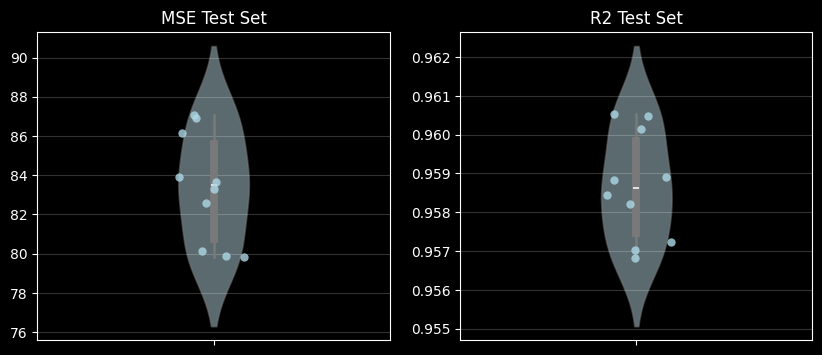


===== CV Results =====
Moyenne R2 test : 0.9168   (std = 0.0004)
Moyenne MSE test : 167.7957 (std = 0.9479)


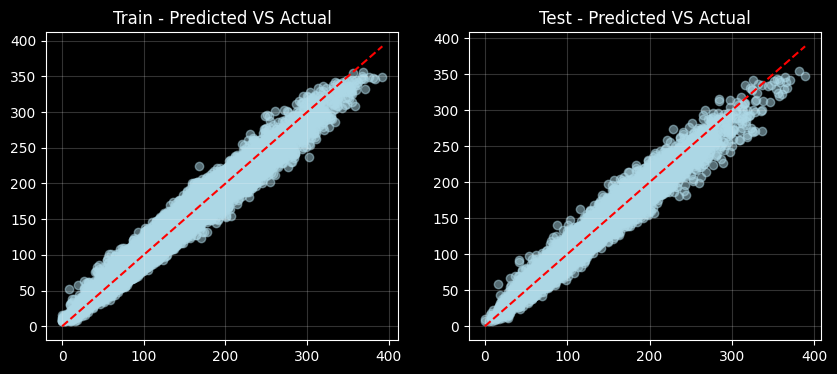

In [193]:
model_analysis(tree_cv_results_mse, tree_cv_results_r2, train_set, test_set, color= 'lightblue')

#### Choose optimal depth (Bias VS Variance)

In [52]:
cv_tree_depth = []
cv_tree_R2 = []
cv_tree_r2_std = []
cv_tree_mse = []
cv_tree_mse_std = []

for each in range(1, 31):

    cv_tree_depth.append(each)
    
    tree = DecisionTreeRegressor(max_depth=each, random_state=42)

    tree_cv_results_r2 = []
    tree_cv_results_mse = []

    for fold, s in enumerate(splits, 1):

        # Convert to DataFrame
        train_set = pd.DataFrame(s["train"]).copy()
        test_set = pd.DataFrame(s["test"]).copy()

        # Encode product_id
        train_set["product_id_int"] = train_set["product_id"].astype("category").cat.codes
        test_set["product_id_int"] = test_set["product_id"].astype("category").cat.codes

        # Define features / target
        X_train = train_set.drop(columns=[
            'product_name', 'initial_price', 'id', 'promo', 'sell_price',
            'date', 'Date', 'no_promo', 'decomposition1', 'sales', 'product_id'
        ])
        X_test = test_set.drop(columns=[
            'product_name', 'initial_price', 'id', 'promo', 'sell_price',
            'date', 'Date', 'no_promo', 'decomposition1', 'sales', 'product_id'
        ])

        y_train = train_set['sales']
        y_test = test_set['sales']

        # Fit model
        tree.fit(X_train, y_train)

        # Predictions
        y_hat_train = tree.predict(X_train)
        y_hat_test = tree.predict(X_test)

        # === EVALUATION ===
        r2_test = r2_score(y_test, y_hat_test)
        mse_test = mean_squared_error(y_test, y_hat_test)

        tree_cv_results_r2.append(r2_test)
        tree_cv_results_mse.append(mse_test)

    # Store aggregated CV results
    cv_tree_R2.append(np.mean(tree_cv_results_r2))
    cv_tree_r2_std.append(np.std(tree_cv_results_r2))
    cv_tree_mse.append(np.mean(tree_cv_results_mse))
    cv_tree_mse_std.append(np.std(tree_cv_results_mse))

# ---- FIXED DATAFRAME ----
cv_tree_depth_compare = pd.DataFrame({
    "depth": cv_tree_depth,
    "R2_mean": cv_tree_R2,
    "R2_std": cv_tree_r2_std,
    "MSE_mean": cv_tree_mse,
    "MSE_std": cv_tree_mse_std
})

Text(0.5, 1.0, 'Std CV MSE ')

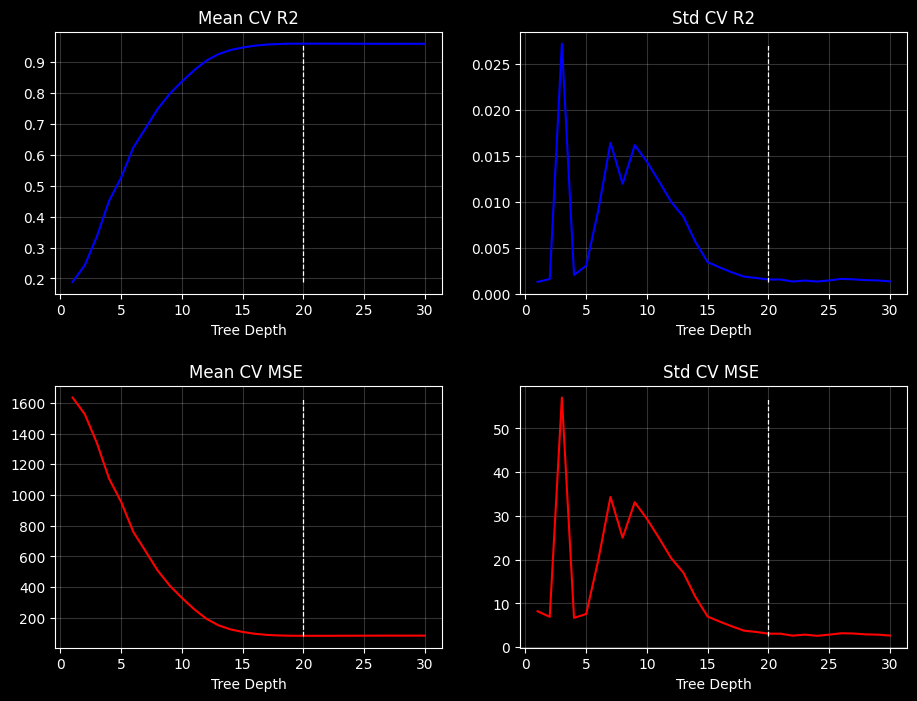

In [53]:
_, ax = plt.subplots(2, 2, figsize=(11, 8))
plt.subplots_adjust(hspace=0.35)

ax[0, 0].plot(cv_tree_depth_compare["depth"], cv_tree_depth_compare["R2_mean"], color = 'b')
ax[0, 0].vlines(x=20, ymin=cv_tree_depth_compare["R2_mean"].min(), ymax=cv_tree_depth_compare["R2_mean"].max(), linestyle='--', linewidth=0.9)
ax[0, 0].set_xlabel("Tree Depth")
ax[0, 0].set_title("Mean CV R2")

ax[0, 1].plot(cv_tree_depth_compare["depth"], cv_tree_depth_compare["R2_std"], color = 'b')
ax[0, 1].vlines(x=20, ymin=cv_tree_depth_compare["R2_std"].min(), ymax=cv_tree_depth_compare["R2_std"].max(), linestyle='--', linewidth=0.9)
ax[0, 1].set_xlabel("Tree Depth")
ax[0, 1].set_title("Std CV R2")

ax[1, 0].plot(cv_tree_depth_compare["depth"], cv_tree_depth_compare["MSE_mean"], color='r')
ax[1, 0].vlines(x=20, ymin=cv_tree_depth_compare["MSE_mean"].min(), ymax=cv_tree_depth_compare["MSE_mean"].max(), linestyle='--', linewidth=0.9)
ax[1, 0].set_xlabel("Tree Depth")
ax[1, 0].set_title("Mean CV MSE ")

ax[1, 1].plot(cv_tree_depth_compare["depth"], cv_tree_depth_compare["MSE_std"], color='r')
ax[1, 1].vlines(x=20, ymin=cv_tree_depth_compare["MSE_std"].min(), ymax=cv_tree_depth_compare["MSE_std"].max(), linestyle='--', linewidth=0.9)
ax[1, 1].set_xlabel("Tree Depth")
ax[1, 1].set_title("Std CV MSE ")

### Random forest

In [54]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf_train_r2 = []
rf_train_mse = []
rf_cv_results_r2 = []
rf_cv_results_mse = []

for fold, s in enumerate(splits, 1):

    # Convert to DataFrame
    train_set = pd.DataFrame(s["train"]).copy()
    test_set = pd.DataFrame(s["test"]).copy()

    # Encode product_id
    train_set["product_id_int"] = train_set["product_id"].astype("category").cat.codes
    test_set["product_id_int"] = test_set["product_id"].astype("category").cat.codes

    # Define features / target
    X_train = train_set.drop(columns=[
        'product_name', 'initial_price', 'id', 'promo', 'sell_price',
        'date', 'Date', 'no_promo', 'decomposition1', 'sales', 'product_id'
    ])
    X_test = test_set.drop(columns=[
        'product_name', 'initial_price', 'id', 'promo', 'sell_price',
        'date', 'Date', 'no_promo', 'decomposition1', 'sales', 'product_id'
    ])

    y_train = train_set['sales']
    y_test = test_set['sales']

    # Fit model
    rf.fit(X_train, y_train)

    # Predictions
    train_set['y_hat'] = rf.predict(X_train)
    test_set['y_hat'] = rf.predict(X_test)

    # === EVALUATION ===
    r2_train = r2_score(y_train, train_set['y_hat'])
    mse_train = mean_squared_error(y_train, train_set['y_hat'])

    r2_test = r2_score(y_test, test_set['y_hat'])
    mse_test = mean_squared_error(y_test, test_set['y_hat'])

    # Store results
    rf_train_r2.append(r2_train)
    rf_train_mse.append(mse_train)
    rf_cv_results_r2.append(r2_test)
    rf_cv_results_mse.append(mse_test)

    print(f"Fold {fold} TRAIN - R2 : {r2_train:.4f} | MSE : {mse_train:.4f}")
    print(f"Fold {fold} TEST  - R2 : {r2_test:.4f} | MSE : {mse_test:.4f}\n")

print("\n===== CV Results (Random Forest) =====")
print(f"Moyenne R2 test : {np.mean(rf_cv_results_r2):.4f}   (std = {np.std(rf_cv_results_r2):.4f})")
print(f"Moyenne MSE test : {np.mean(rf_cv_results_mse):.4f} (std = {np.std(rf_cv_results_mse):.4f})")

Fold 1 TRAIN - R2 : 0.9956 | MSE : 8.6476
Fold 1 TEST  - R2 : 0.9757 | MSE : 48.5743

Fold 2 TRAIN - R2 : 0.9957 | MSE : 8.5307
Fold 2 TEST  - R2 : 0.9744 | MSE : 51.2865

Fold 3 TRAIN - R2 : 0.9956 | MSE : 8.7319
Fold 3 TEST  - R2 : 0.9756 | MSE : 49.0938

Fold 4 TRAIN - R2 : 0.9956 | MSE : 8.7756
Fold 4 TEST  - R2 : 0.9762 | MSE : 48.1696

Fold 5 TRAIN - R2 : 0.9955 | MSE : 8.9259
Fold 5 TEST  - R2 : 0.9757 | MSE : 49.3249

Fold 6 TRAIN - R2 : 0.9955 | MSE : 8.9121
Fold 6 TEST  - R2 : 0.9733 | MSE : 53.7019

Fold 7 TRAIN - R2 : 0.9954 | MSE : 9.1860
Fold 7 TEST  - R2 : 0.9745 | MSE : 51.4336

Fold 8 TRAIN - R2 : 0.9953 | MSE : 9.3844
Fold 8 TEST  - R2 : 0.9754 | MSE : 49.7337

Fold 9 TRAIN - R2 : 0.9952 | MSE : 9.5786
Fold 9 TEST  - R2 : 0.9750 | MSE : 50.4302

Fold 10 TRAIN - R2 : 0.9952 | MSE : 9.5181
Fold 10 TEST  - R2 : 0.9738 | MSE : 52.9994


===== CV Results (Random Forest) =====
Moyenne R2 test : 0.9750   (std = 0.0009)
Moyenne MSE test : 50.4748 (std = 1.7627)


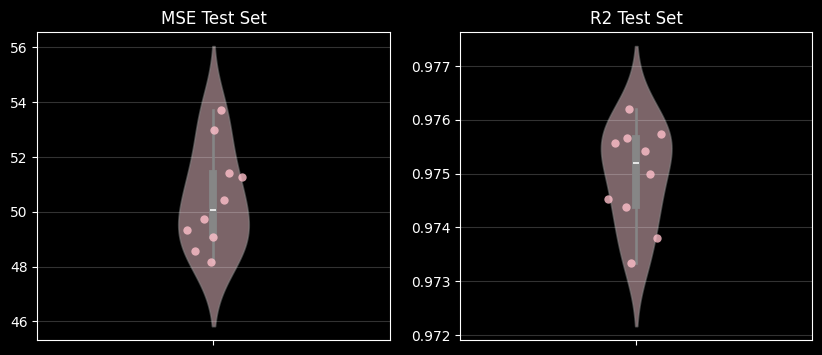


===== CV Results =====
Moyenne R2 test : 0.9168   (std = 0.0004)
Moyenne MSE test : 167.7957 (std = 0.9479)


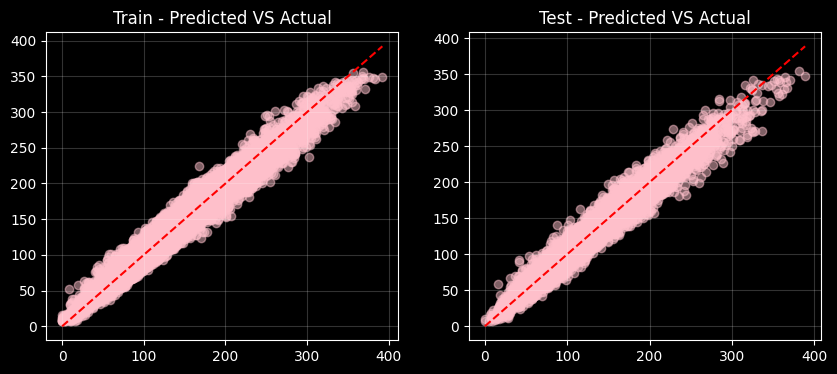

In [198]:
model_analysis(rf_cv_results_mse, rf_cv_results_r2, train_set, test_set, color= 'pink')

### Gradient boosting (Undeveloped)

In [56]:
hgb = HistGradientBoostingRegressor(
    max_depth=20,
    learning_rate=0.2,
    max_bins=255,
    l2_regularization=0.0,
    random_state=42
)

hgb_train_r2 = []
hgb_train_mse = []
hgb_cv_results_r2 = []
hgb_cv_results_mse = []

for fold, s in enumerate(splits, 1):

    train_set = pd.DataFrame(s["train"]).copy()
    test_set = pd.DataFrame(s["test"]).copy()

    train_set["product_id_int"] = train_set["product_id"].astype("category").cat.codes
    test_set["product_id_int"] = test_set["product_id"].astype("category").cat.codes

    X_train = train_set.drop(columns=[
        'product_name', 'initial_price', 'id', 'promo', 'sell_price',
        'date', 'Date', 'no_promo', 'decomposition1', 'sales', 'product_id'
    ])
    X_test = test_set.drop(columns=[
        'product_name', 'initial_price', 'id', 'promo', 'sell_price',
        'date', 'Date', 'no_promo', 'decomposition1', 'sales', 'product_id'
    ])

    y_train = train_set['sales']
    y_test = test_set['sales']

    # Fit model
    hgb.fit(X_train, y_train)

    # Predictions
    y_hat_train = hgb.predict(X_train)
    y_hat_test = hgb.predict(X_test)

    train_set['y_hat'] = hgb.predict(X_train)
    test_set['y_hat'] = hgb.predict(X_test)

    # Evaluation
    r2_train = r2_score(y_train, train_set['y_hat'])
    mse_train = mean_squared_error(y_train, train_set['y_hat'])
    r2_test = r2_score(y_test, test_set['y_hat'])
    mse_test = mean_squared_error(y_test, test_set['y_hat'])

    hgb_train_r2.append(r2_train)
    hgb_train_mse.append(mse_train)
    hgb_cv_results_r2.append(r2_test)
    hgb_cv_results_mse.append(mse_test)

    print(f"Fold {fold} TRAIN  - R2 : {r2_train:.4f} | MSE : {mse_train:.4f}")
    print(f"Fold {fold} TEST  - R2 : {r2_test:.4f} | MSE : {mse_test:.4f}\n")

print("\n===== HistGradientBoosting CV Results =====")
print(f"Mean R2 test : {np.mean(hgb_cv_results_r2):.4f}")
print(f"Mean MSE test : {np.mean(hgb_cv_results_mse):.4f}")

Fold 1 TRAIN  - R2 : 0.9707 | MSE : 58.1843
Fold 1 TEST  - R2 : 0.9623 | MSE : 75.5736

Fold 2 TRAIN  - R2 : 0.9715 | MSE : 56.5783
Fold 2 TEST  - R2 : 0.9624 | MSE : 75.1832

Fold 3 TRAIN  - R2 : 0.9711 | MSE : 57.4843
Fold 3 TEST  - R2 : 0.9618 | MSE : 76.7440

Fold 4 TRAIN  - R2 : 0.9693 | MSE : 60.9162
Fold 4 TEST  - R2 : 0.9616 | MSE : 77.7982

Fold 5 TRAIN  - R2 : 0.9693 | MSE : 61.0193
Fold 5 TEST  - R2 : 0.9614 | MSE : 78.2391

Fold 6 TRAIN  - R2 : 0.9697 | MSE : 60.4114
Fold 6 TEST  - R2 : 0.9602 | MSE : 80.0833

Fold 7 TRAIN  - R2 : 0.9700 | MSE : 59.7892
Fold 7 TEST  - R2 : 0.9614 | MSE : 77.9628

Fold 8 TRAIN  - R2 : 0.9709 | MSE : 58.1100
Fold 8 TEST  - R2 : 0.9634 | MSE : 74.0895

Fold 9 TRAIN  - R2 : 0.9691 | MSE : 61.7880
Fold 9 TEST  - R2 : 0.9607 | MSE : 79.3129

Fold 10 TRAIN  - R2 : 0.9707 | MSE : 58.5477
Fold 10 TEST  - R2 : 0.9613 | MSE : 78.2882


===== HistGradientBoosting CV Results =====
Mean R2 test : 0.9616
Mean MSE test : 77.3275


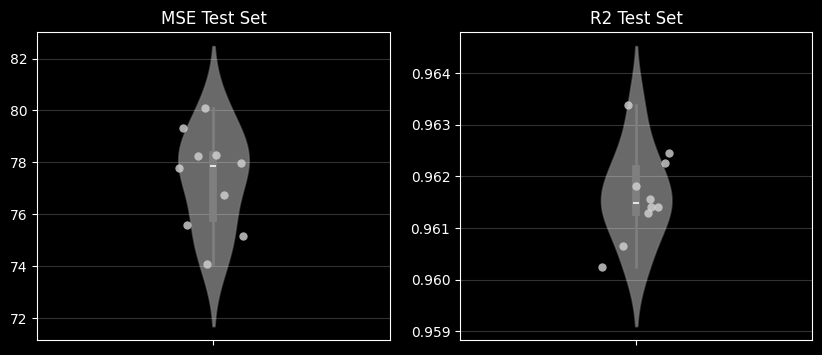


===== CV Results =====
Moyenne R2 test : 0.9168   (std = 0.0004)
Moyenne MSE test : 167.7957 (std = 0.9479)


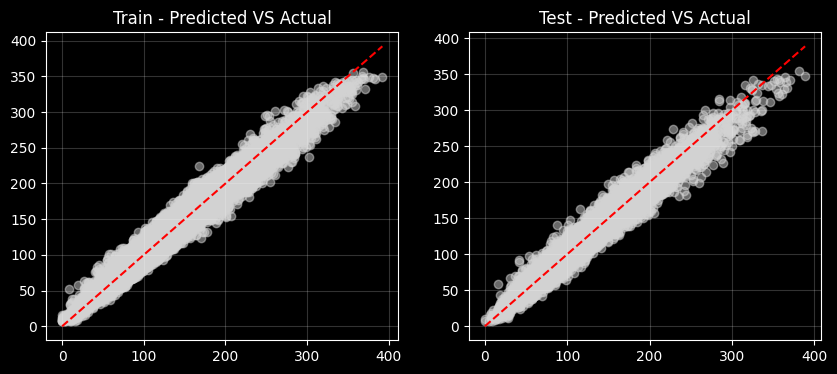

In [205]:
model_analysis(hgb_cv_results_mse, hgb_cv_results_r2, train_set, test_set, color = 'lightgray')

### Compare all models 

In order to compare our models, we'll compare either the $R^2$ and the $MSE$. 

Our criterium are : 
- Max $R^2$ and Min $MSE$
- Minimize variance of both.

We can see on the folowing plots that the model that did the better job is Random Forest. In fact, the random forest managed to have the highest $R^2$ and the lowest $MSE$.

But also keeping a low variance. 

Therefore, the linear model did a good job generalising. In fact, it's variance is very low compared to the others. 

In [58]:
cv_results_df = pd.DataFrame({
    "linear_model_R2": cv_results_r2, 
    "linear_model_MSE": cv_results_mse,
    "tree_R2": tree_cv_results_r2,
    "tree_MSE": tree_cv_results_mse,
    "rf_R2": rf_cv_results_r2,
    "rf_MSE": rf_cv_results_mse,
    "hgb_R2": hgb_cv_results_r2,
    "hgb_MSE": hgb_cv_results_mse
})

cv_results_long = cv_results_df.melt(
    var_name="model_metric",
    value_name="value"
)

cv_results_long["model"], cv_results_long["metric"] = zip(*cv_results_long["model_metric"].apply(lambda x: x.rsplit("_", 1)))


#### R2

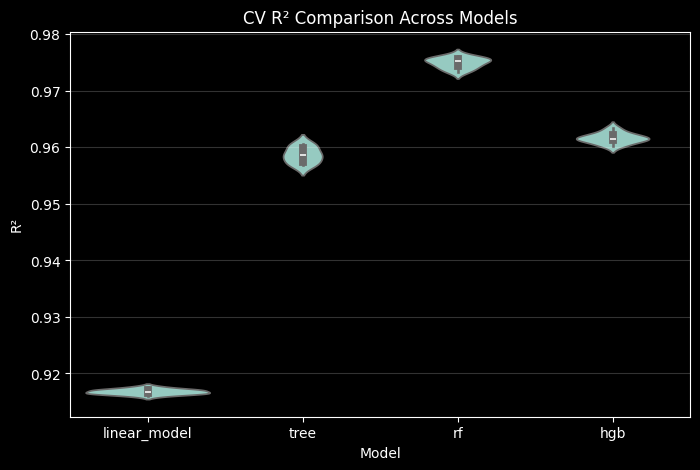

In [154]:
plt.figure(figsize=(8,5))
sns.violinplot(x="model", y="value", data=cv_results_long[cv_results_long["metric"]=="R2"])
#sns.stripplot(x="model", y="value", data=cv_results_long[cv_results_long["metric"]=="R2"])
plt.title("CV R² Comparison Across Models")
plt.ylabel("R²")
plt.xlabel("Model")
plt.show()

#### MSE

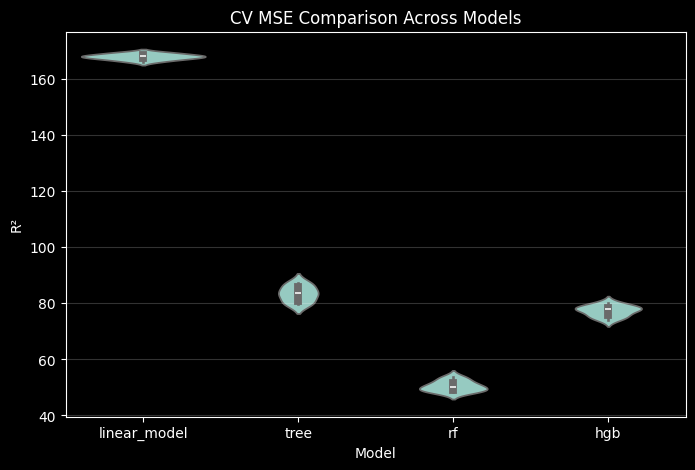

In [60]:
plt.figure(figsize=(8,5))
sns.violinplot(x="model", y="value", data=cv_results_long[cv_results_long["metric"]=="MSE"])
plt.title("CV MSE Comparison Across Models")
plt.ylabel("R²")
plt.xlabel("Model")
plt.show()

## Optimize promotion policy

### Build an empty 2025 data set

In [61]:
dates_2025 = pd.date_range(start="2025-01-01", end="2025-12-31", freq="D")

empty_2025 = pd.MultiIndex.from_product(
    [df.product_id.unique(), dates_2025],
    names=["product_id", "date"]
).to_frame(index=False)

empty_2025['year'] = empty_2025.date.dt.year
empty_2025['month'] = empty_2025.date.dt.month
empty_2025['day'] = empty_2025.date.dt.day
empty_2025['dayofweek'] = empty_2025.date.dt.dayofweek

empty_2025["product_id_int"] = empty_2025["product_id"].astype("category").cat.codes


initial_prices = [
    8.5, 9.0, 10.5, 9.5, 11.0,
    9.5, 10.0, 8.5, 9.5, 10.0,
    11.5, 12.0, 11.0, 13.0, 12.5,
    13.5, 14.5, 12.0, 13.0, 14.0
]

price_mapping = {f"Product_{i+1}": initial_prices[i] for i in range(len(initial_prices))}

empty_2025["initial_price"] = empty_2025["product_id"].map(price_mapping)

for i, each in zip(
    [0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5], 
    [0, 5, 10, 15, 20, 30, 40, 50]
):
    empty_2025[f'promo{each}'] = i

for i in [0, 5, 10, 15, 20, 30, 40, 50] : 
    empty_2025[f'sell_price{i}'] = empty_2025['initial_price'] - empty_2025['initial_price'] * empty_2025[f'promo{i}']


In [62]:
empty_2025

,product_id,date,year,month,day,dayofweek,product_id_int,initial_price,promo0,promo5,...,promo40,promo50,sell_price0,sell_price5,sell_price10,sell_price15,sell_price20,sell_price30,sell_price40,sell_price50
0,Product_1,2025-01-01,2025,1,1,2,0,8.5,0,0.05,...,0.4,0.5,8.5,8.075,7.65,7.225,6.8,5.95,5.1,4.25
1,Product_1,2025-01-02,2025,1,2,3,0,8.5,0,0.05,...,0.4,0.5,8.5,8.075,7.65,7.225,6.8,5.95,5.1,4.25
2,Product_1,2025-01-03,2025,1,3,4,0,8.5,0,0.05,...,0.4,0.5,8.5,8.075,7.65,7.225,6.8,5.95,5.1,4.25
3,Product_1,2025-01-04,2025,1,4,5,0,8.5,0,0.05,...,0.4,0.5,8.5,8.075,7.65,7.225,6.8,5.95,5.1,4.25
4,Product_1,2025-01-05,2025,1,5,6,0,8.5,0,0.05,...,0.4,0.5,8.5,8.075,7.65,7.225,6.8,5.95,5.1,4.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7295,Product_20,2025-12-27,2025,12,27,5,12,14.0,0,0.05,...,0.4,0.5,14.0,13.300,12.60,11.900,11.2,9.80,8.4,7.00
7296,Product_20,2025-12-28,2025,12,28,6,12,14.0,0,0.05,...,0.4,0.5,14.0,13.300,12.60,11.900,11.2,9.80,8.4,7.00
7297,Product_20,2025-12-29,2025,12,29,0,12,14.0,0,0.05,...,0.4,0.5,14.0,13.300,12.60,11.900,11.2,9.80,8.4,7.00
7298,Product_20,2025-12-30,2025,12,30,1,12,14.0,0,0.05,...,0.4,0.5,14.0,13.300,12.60,11.900,11.2,9.80,8.4,7.00


### Predict the sales for different levels of promotion

In [63]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

df["product_id_int"] = df["product_id"].astype("category").cat.codes
X = df[['product_id_int', 'year', 'month', 'day', 'dayofweek', 'promotion']]
y = df['sales']

rf.fit(X, y)


for i in [0, 5, 10, 15, 20, 30, 40, 50] : 
    empty_2025['promotion'] = empty_2025[f'promo{i}']
    empty_2025[f'sales{i}'] =  rf.predict(empty_2025[['product_id_int', 'year', 'month', 'day', 'dayofweek', 'promotion']])


In [64]:
empty_2025 = empty_2025.set_index(empty_2025.date)

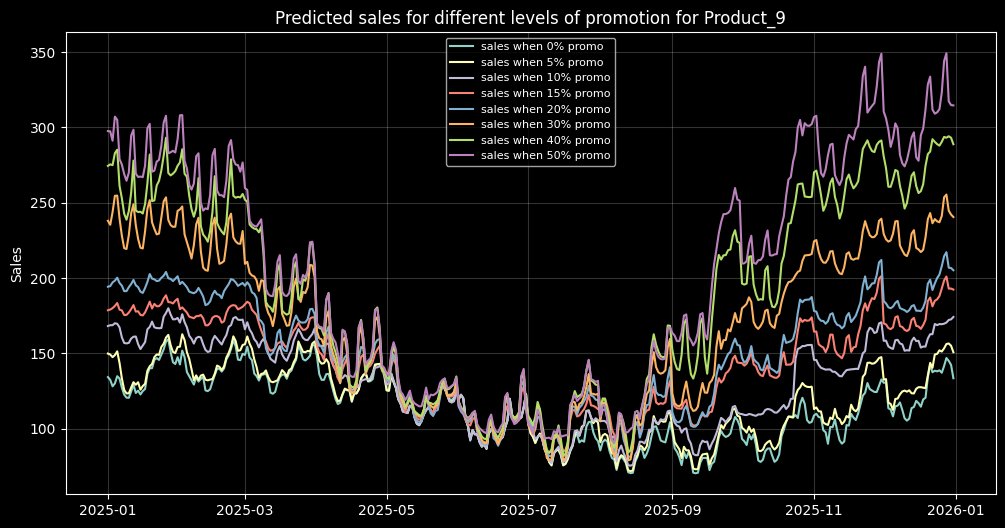

In [65]:
prod = 'Product_9'
sub = empty_2025[empty_2025.product_id == prod]

plt.figure(figsize = (12, 6))

for each in [0, 5, 10, 15, 20, 30, 40, 50] : 
    plt.plot(sub.date, sub[f'sales{each}'], alpha = 1, label=f'sales when {each}% promo')

plt.ylabel('Sales')
plt.title(f'Predicted sales for different levels of promotion for {prod}')
plt.legend( fontsize=8)

### Give the profit for different levels of promotion

In [66]:
for i in [0, 5, 10, 15, 20, 30, 40, 50] : 
    empty_2025[f'profit{i}'] = empty_2025[f'sales{i}'] * empty_2025[f'sell_price{i}']

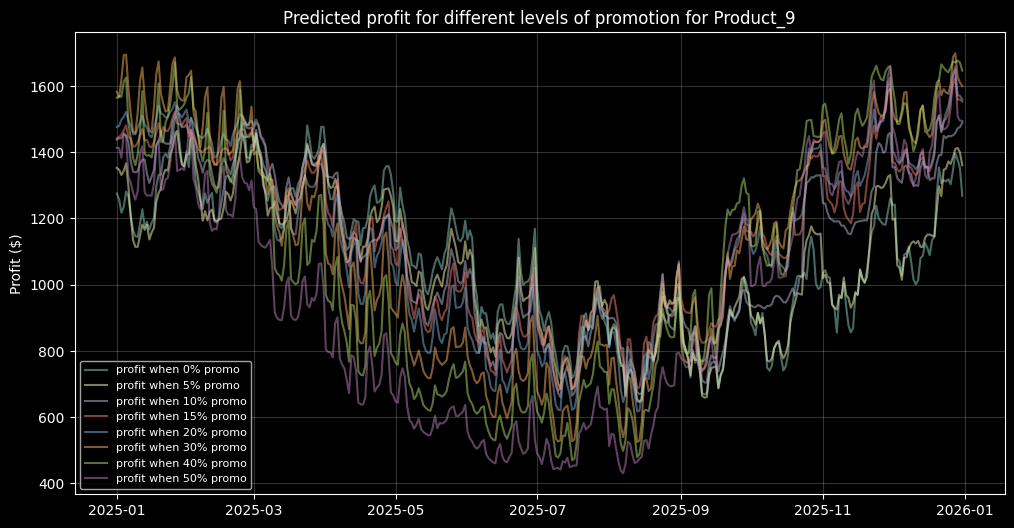

In [67]:
prod = 'Product_9'
sub = empty_2025[empty_2025.product_id == prod]

plt.figure(figsize = (12, 6))

for each in [0, 5, 10, 15, 20, 30, 40, 50] : 
    plt.plot(sub.date, sub[f'profit{each}'], alpha = 0.5, label=f'profit when {each}% promo')

plt.ylabel('Profit ($)')
plt.title(f'Predicted profit for different levels of promotion for {prod}')
plt.legend( fontsize=8)

### Optimisation

#### Illustrate promotion effect

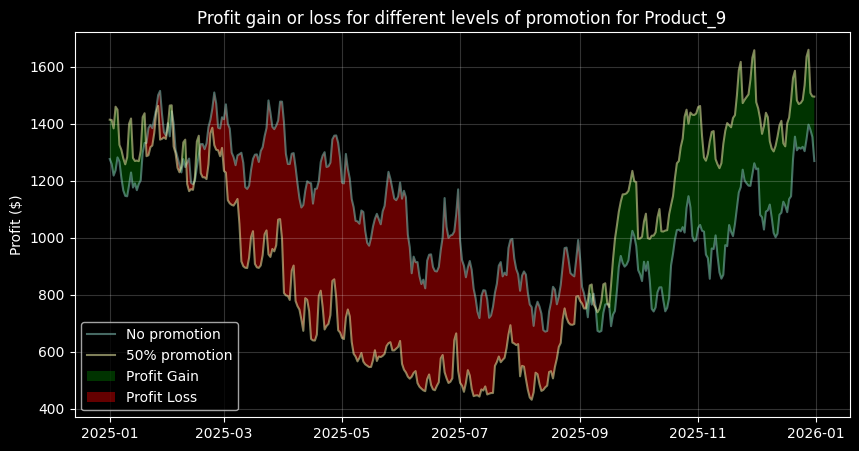

In [68]:
prod = 'Product_9'
sub = empty_2025[empty_2025.product_id == 'Product_9']

plt.figure(figsize = (10, 5))
plt.plot(sub.date, sub.profit0, label='No promotion', alpha = 0.5)
plt.plot(sub.date, sub.profit50, label='50% promotion', alpha = 0.5)

plt.fill_between(sub.date, sub.profit0, sub.profit50, where=(sub.profit50 > sub.profit0), 
                 facecolor='green', alpha=0.4, interpolate=True, label='Profit Gain')

plt.fill_between(sub.date, sub.profit0, sub.profit50, where=(sub.profit50 <= sub.profit0), 
                 facecolor='red', alpha=0.4, interpolate=True, label='Profit Loss')

plt.ylabel('Profit ($)')
plt.title(f'Profit gain or loss for different levels of promotion for {prod}')
plt.legend()

#### Give the best profit between all predictions 

In [69]:
profit_cols = ["profit0","profit5","profit10","profit15",
               "profit20","profit30","profit40","profit50"]


empty_2025["best_profit"] = (
    empty_2025[profit_cols]
    .idxmax(axis=1)            
    .str.replace("profit", "") 
    .astype(int)            
)

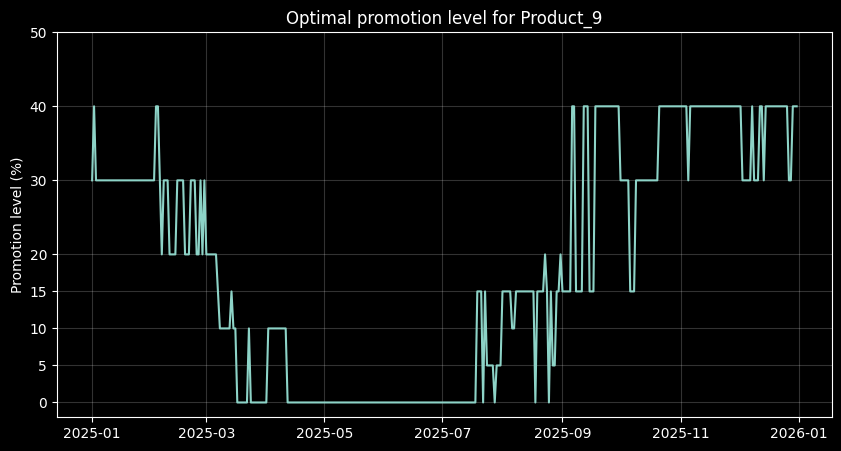

In [70]:
prod = 'Product_9'
sub = empty_2025[empty_2025.product_id == prod]

plt.figure(figsize = (10, 5))
plt.plot(sub.date, sub.best_profit)
plt.title(f'Optimal promotion level for {prod}')
plt.yticks([0, 5, 10, 15, 20, 30, 40, 50])
plt.ylabel('Promotion level (%)')
plt.show()

#### Simulate optimisation performance

In [71]:
empty_2025["optimal_curve"] = empty_2025[profit_cols].max(axis=1)

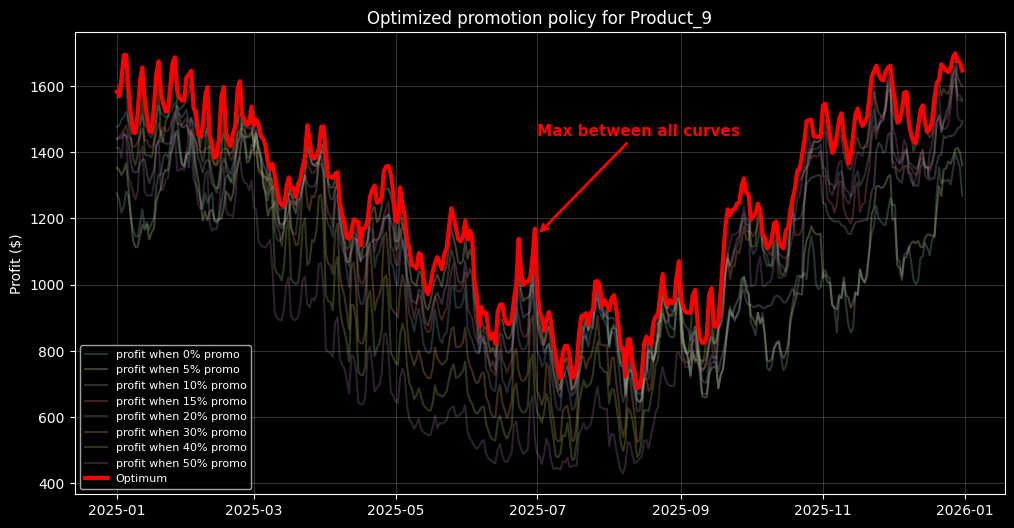

In [72]:
prod = 'Product_9'
sub = empty_2025[empty_2025.product_id == prod]

plt.figure(figsize = (12, 6))

for each in [0, 5, 10, 15, 20, 30, 40, 50] : 
    plt.plot(sub.date, sub[f'profit{each}'], alpha = 0.25, label=f'profit when {each}% promo')

plt.plot(sub.date, sub.optimal_curve, color = 'r', label='Optimum', linewidth=3)

plt.annotate(
    f'Max between all curves',              
    xy=(pd.to_datetime('2025-07-01'), 1150),   
    xytext=(pd.to_datetime('2025-07-01'), 1450), 
    arrowprops=dict(arrowstyle='->', color='r', linewidth=2),
    color='r', fontsize = 11, fontweight='bold'
)

plt.ylabel('Profit ($)')
plt.title(f'Optimized promotion policy for {prod}')
plt.legend( fontsize=8)

In [73]:
df['profit'] = df['sales'] * df['sell_price']
results_profit = df.groupby('year')['profit'].sum()
profit_2025 = empty_2025["optimal_curve"].sum()
results_profit.loc[2025] = profit_2025
results_profit.loc[2024] = results_profit.loc[2024] * 365 / df[(df.year == 2024) & (df.product_id == 'Product_1')]['profit'].count() # Less observations in 2024
results_profit = pd.DataFrame(results_profit)

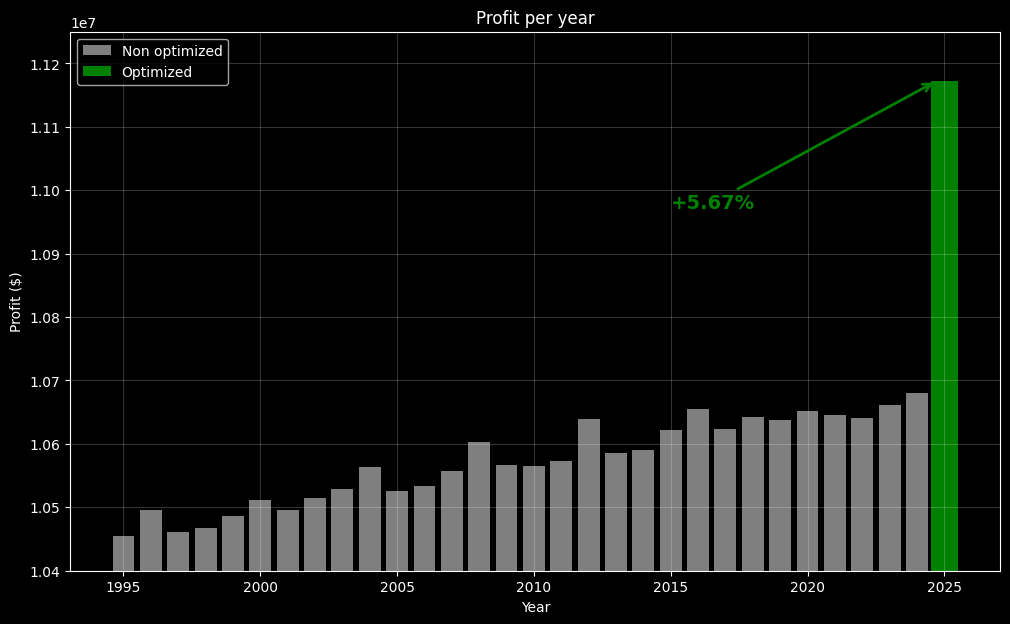

In [74]:
before = results_profit[results_profit.index <= 2024]
after = results_profit[results_profit.index == 2025]

b_mean = before['profit'].mean()
a_mean = after['profit'].mean()

growth = a_mean / b_mean - 1

plt.figure(figsize=(12, 7))
plt.bar(before.index, before.profit, color = 'w', label='Non optimized', alpha = 0.5)
plt.bar(after.index, after.profit, color='g', label='Optimized', width=1)
plt.legend()
plt.ylim(10400000, 11250000)

plt.annotate(
    f'+{growth:.2%}',              
    xy=(2025 - 0.3, after.values[0]),   
    xytext=(2015, after.values[0] - 200000), 
    arrowprops=dict(arrowstyle='->', color='green', linewidth=2),
    color='green', fontsize = 14, fontweight='bold'
)

plt.title('Profit per year')
plt.xlabel('Year')
plt.ylabel('Profit ($)')
plt.show()